## descriptive data exploration
* study the trending of correlation

### feature ranking
* correlation btw each feature and unit price
* random forest ranking


In [1]:
import os,sys
from sqlalchemy import create_engine
import numpy as np
import pandas as pd

cwd = os.getcwd()
lib_path = os.path.abspath(os.path.join(cwd, 'lib'))
sys.path.append(lib_path)
from plot_utils import *

ServerName = "localhost"
Database = "sdra"
engine = create_engine('postgresql://postgres:@' + ServerName + ':5432/' + Database)

### dataset basics

In [2]:
# property
sql = '''SELECT p.* FROM properties p'''
df_property = pd.read_sql_query(sql, engine)
print("all properties:",df_property.shape)

sql = '''SELECT p.* FROM property_features p'''
df_property_features = pd.read_sql_query(sql, engine)
print("property features:",df_property_features.shape)

all properties: (1048575, 17)
property features: (709471, 13)


In [3]:
# valid property joined with addresses
sql = '''SELECT * FROM property_addresses'''
df_property_address = pd.read_sql_query(sql, engine)
df_property_address.shape

(709325, 7)

In [4]:
# total transactions
sql = '''SELECT t.* FROM transactions t'''
df_transaction = pd.read_sql_query(sql, engine)
df_transaction.shape

(2042059, 4)

In [5]:
# all valid transactions of valid property with addresses
sql = '''SELECT * FROM property_address_transactions'''
df_all = pd.read_sql_query(sql, engine)
df_all['unit_price'] = df_all['sold_price'] / df_all['sqft']
df_all['date'] = pd.to_datetime(df_all['date'])
df_all['sold_year'], df_all['sold_month'] = df_all['date'].dt.year, df_all['date'].dt.month
print(df_all.shape)
df_all[:3]

(1543380, 26)


,pin,land_use_code,land_use_subcode,year_built,sqft,num_bed,num_bath,par_addition_area,num_units,par_current_land,...,unit_no,city,zip,code,sold_price,date,sold_age,unit_price,sold_year,sold_month
0,5754330300,1,11,1955.0,1120,3.0,15.0,0,1,133145,...,None,CHULA VISTA,91911,,447000,2017-10-24,62.0,399.107143,2017,10
1,1657014212,1,17,1993.0,1016,2.0,20.0,0,1,234000,...,90,OCEANSIDE,92056,,397000,2017-10-19,24.0,390.748031,2017,10
2,5426810623,1,17,1979.0,753,2.0,10.0,0,1,50699,...,23,SAN DIEGO,92105,,210000,2017-09-27,38.0,278.884462,2017,9


### yearly trending of feature correlation

In [6]:
df_all_valid = df_all[(df_all['unit_price']<1000)
                    &(df_all['code']!='M')
                    &(df_all['year_built'] > 0)
                    #&(df_all['sold_year']>2000) 
                    &(df_all['sold_age'] > 0)
                    ]
df_all_valid.shape

(1152680, 26)

In [7]:
df_all_valid['year_built'] = df_all_valid['year_built'].astype(int)

C:\Users\wenyan\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [8]:
# last year transactions of valid properties
df_last_year = df_all_valid[(df_all_valid['date'] >= '2016-10-01') & (df_all_valid['date'] < '2017-10-01')]
df_last_year.shape

(36123, 26)

In [9]:
# remove outliers
df_last_year_valid = df_last_year[(df_last_year['unit_price']<1500) & (df_last_year['unit_price']>0)]
print("last year valid data size:", df_last_year_valid.shape)

last year valid data size: (36123, 26)


### price/unit price correlation
* with geography: street, zip, city
* with transaction#
* with property characteristic: sqft, lot_size_sqft

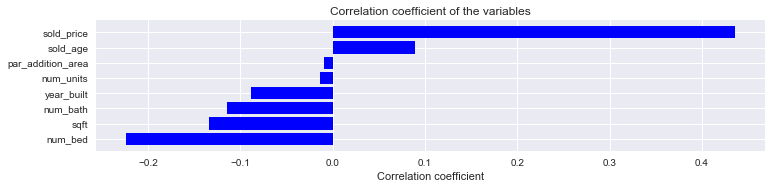

In [10]:
features = set(df_property_features.columns) - set(['pin', 'land_use_code', 'land_use_subcode', 'par_personal_property', 'par_current_land', 'par_current_imps', 'par_tax_status']) 
features |= set(['sold_age', 'sold_price'])

df_corr_unit_price = plot_correlation(df_last_year_valid, 'unit_price', features)

In [11]:
year_begin, year_end = df_all_valid['sold_year'].min(), df_all_valid['sold_year'].max()

In [12]:
corrs = []
for year in range(year_begin, year_end+1):
    df_year = df_all_valid[df_all_valid['sold_year']==year]
    print(year, df_year.shape)
    corr = plot_correlation(df_year, 'unit_price', features, False)
    corr['year'] = year
    corrs.append(corr)

1983 (22935, 26)
1984 (23623, 26)
1985 (25602, 26)
1986 (31929, 26)
1987 (32398, 26)
1988 (38129, 26)
1989 (37948, 26)
1990 (28918, 26)
1991 (24763, 26)
1992 (24478, 26)
1993 (24900, 26)
1994 (26948, 26)
1995 (22535, 26)
1996 (26506, 26)
1997 (31369, 26)
1998 (38646, 26)
1999 (41383, 26)
2000 (39732, 26)
2001 (37587, 26)
2002 (43160, 26)
2003 (46494, 26)
2004 (48443, 26)
2005 (44643, 26)
2006 (32912, 26)
2007 (26702, 26)
2008 (29618, 26)
2009 (34843, 26)
2010 (32264, 26)
2011 (31468, 26)
2012 (35670, 26)
2013 (36705, 26)
2014 (29369, 26)
2015 (35730, 26)
2016 (36899, 26)
2017 (27431, 26)


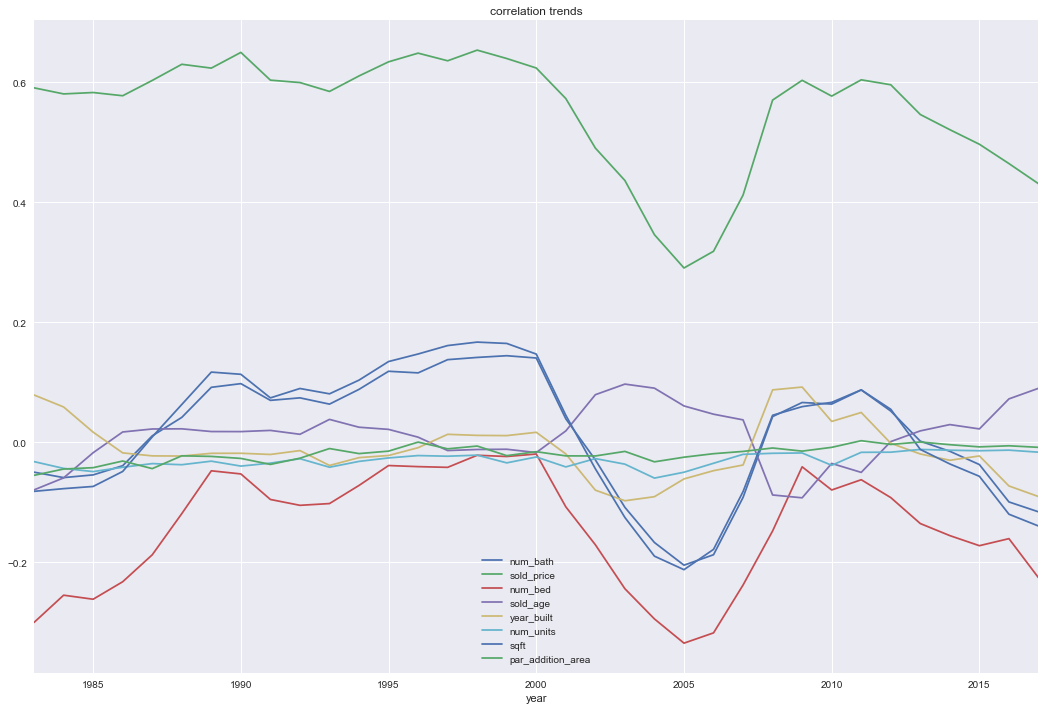

In [13]:
df_corr_all = pd.DataFrame(corrs).set_index(['year'])
plot_trends(df_corr_all, features, 'correlation trends')

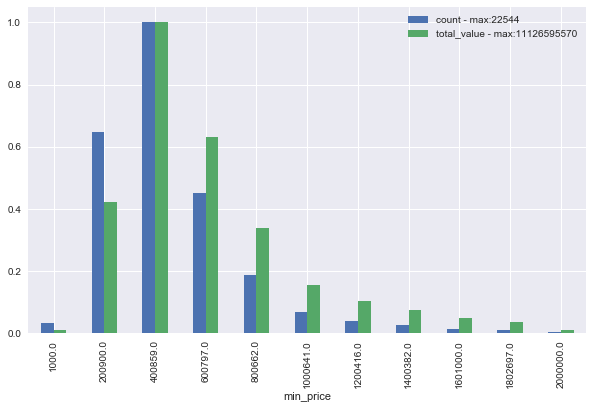

In [19]:
sql_1year = '''
SELECT * FROM property_transactions
WHERE date between '2005-01-01' AND '2005-12-31'
ORDER by date DESC
'''
df = get_hist_on_price(engine, sql_1year, 'sold_price', 0, 2000000, 10)
plot_histogram_group_scaled(df, 'min_price', ['count', 'total_value'])

### unit price trend of brackets on features
* continuous numeric features
* sqft
* sold_price
* year_built

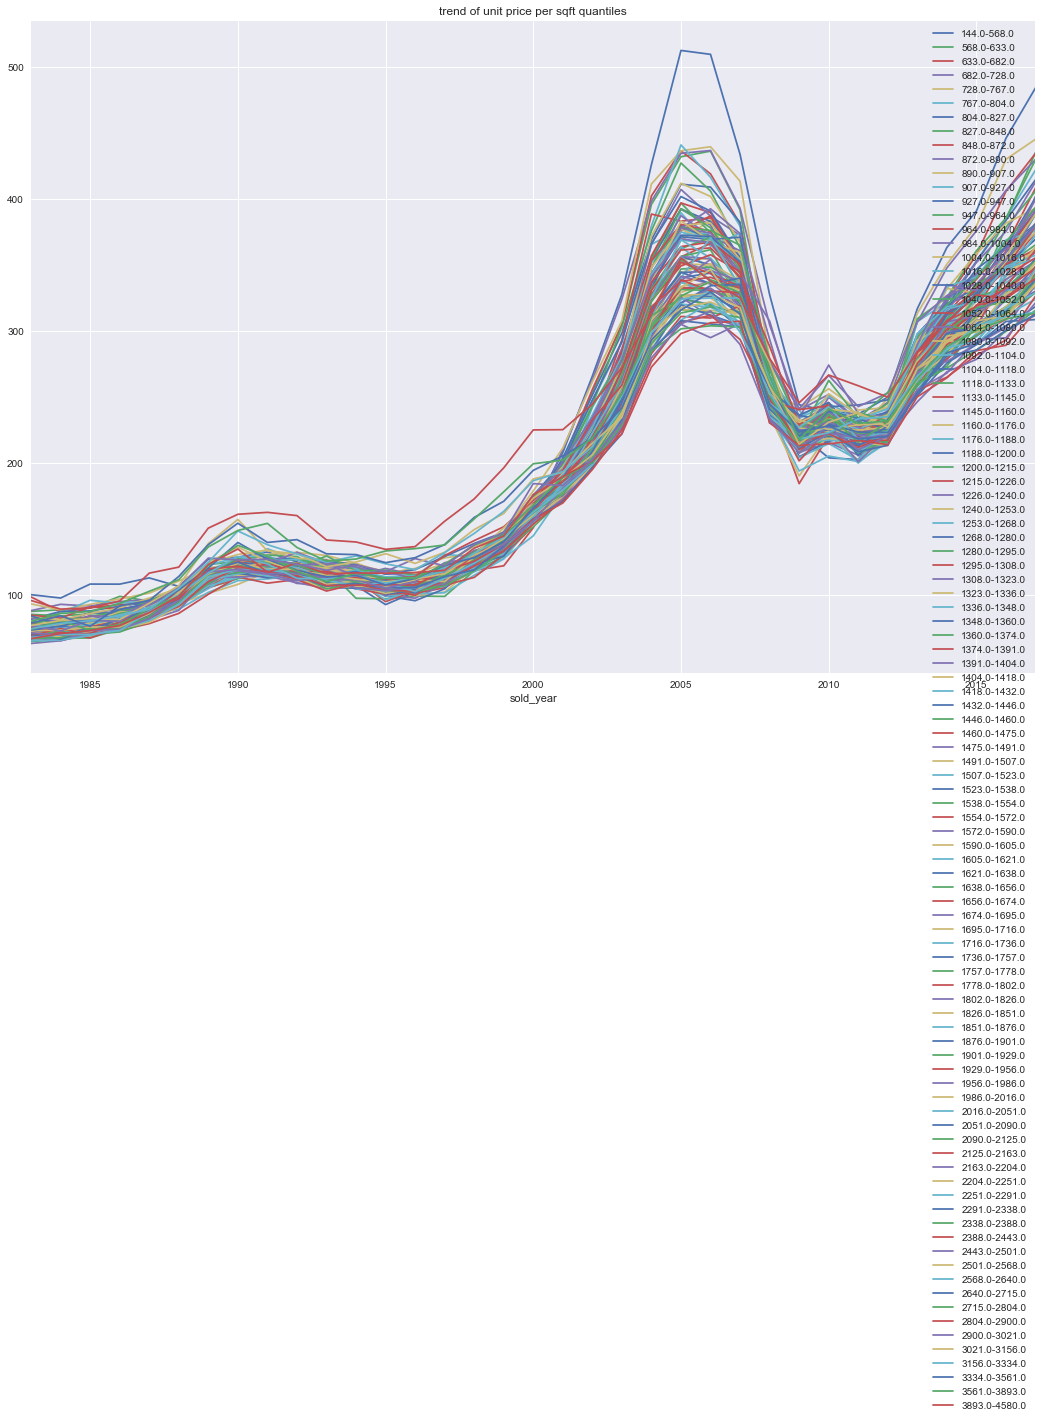

In [14]:
# segmented by sqft range
num_brackets = 100
sqft_segments = [df_all_valid['sqft'].quantile(i/num_brackets) for i in range(num_brackets)]

count = []
data = []
fig, ax = plt.subplots(figsize=(18,12))
for i in range(len(sqft_segments)-1):
    sqft_b,sqft_e = sqft_segments[i], sqft_segments[i+1]
    df_sqft_seg = df_all_valid[(df_all_valid['sqft']>=sqft_b) & (df_all_valid['sqft']<sqft_e)]
    
    bracket = df_sqft_seg.groupby(by=['sold_year'])['unit_price']
    name = "{}-{}".format(sqft_b,sqft_e)
    #print(name, df_sqft_seg.shape[0])
    bracket_count = pd.Series(bracket.count(), name=name)
    count.append(bracket_count)
    df_sqft_seg = bracket.mean()
    data.append(pd.Series(df_sqft_seg, name=name))
    df_sqft_seg.plot(ax=ax, kind='line', label=name)
plt.legend(loc='best')
plt.title("trend of unit price per sqft quantiles")
plt.show()

df_heat = pd.concat(count, axis=1, keys=[s.name for s in count])
df_trend = pd.concat(data, axis=1)

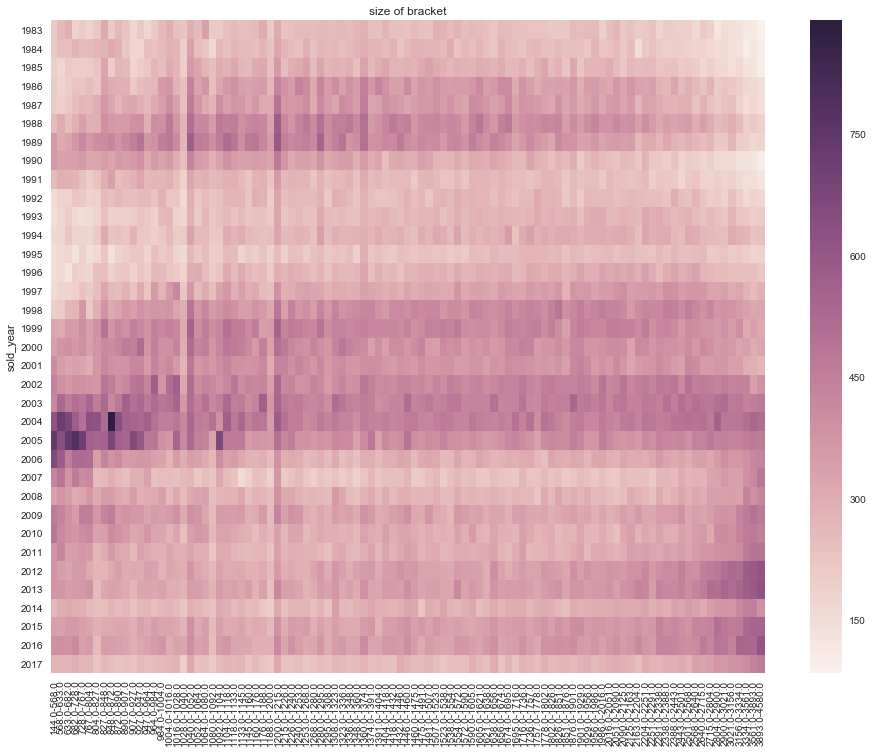

In [21]:
fig,ax = plt.subplots(figsize=(16,12))
ax.set_title('size of bracket')
hm = sns.heatmap(df_heat, ax=ax, annot=False, fmt="d")
plt.show()

In [48]:
year_begin, year_end = df_all_valid['year_built'].min(), df_all_valid['year_built'].max()
year_begin, year_end

(1918, 2017)

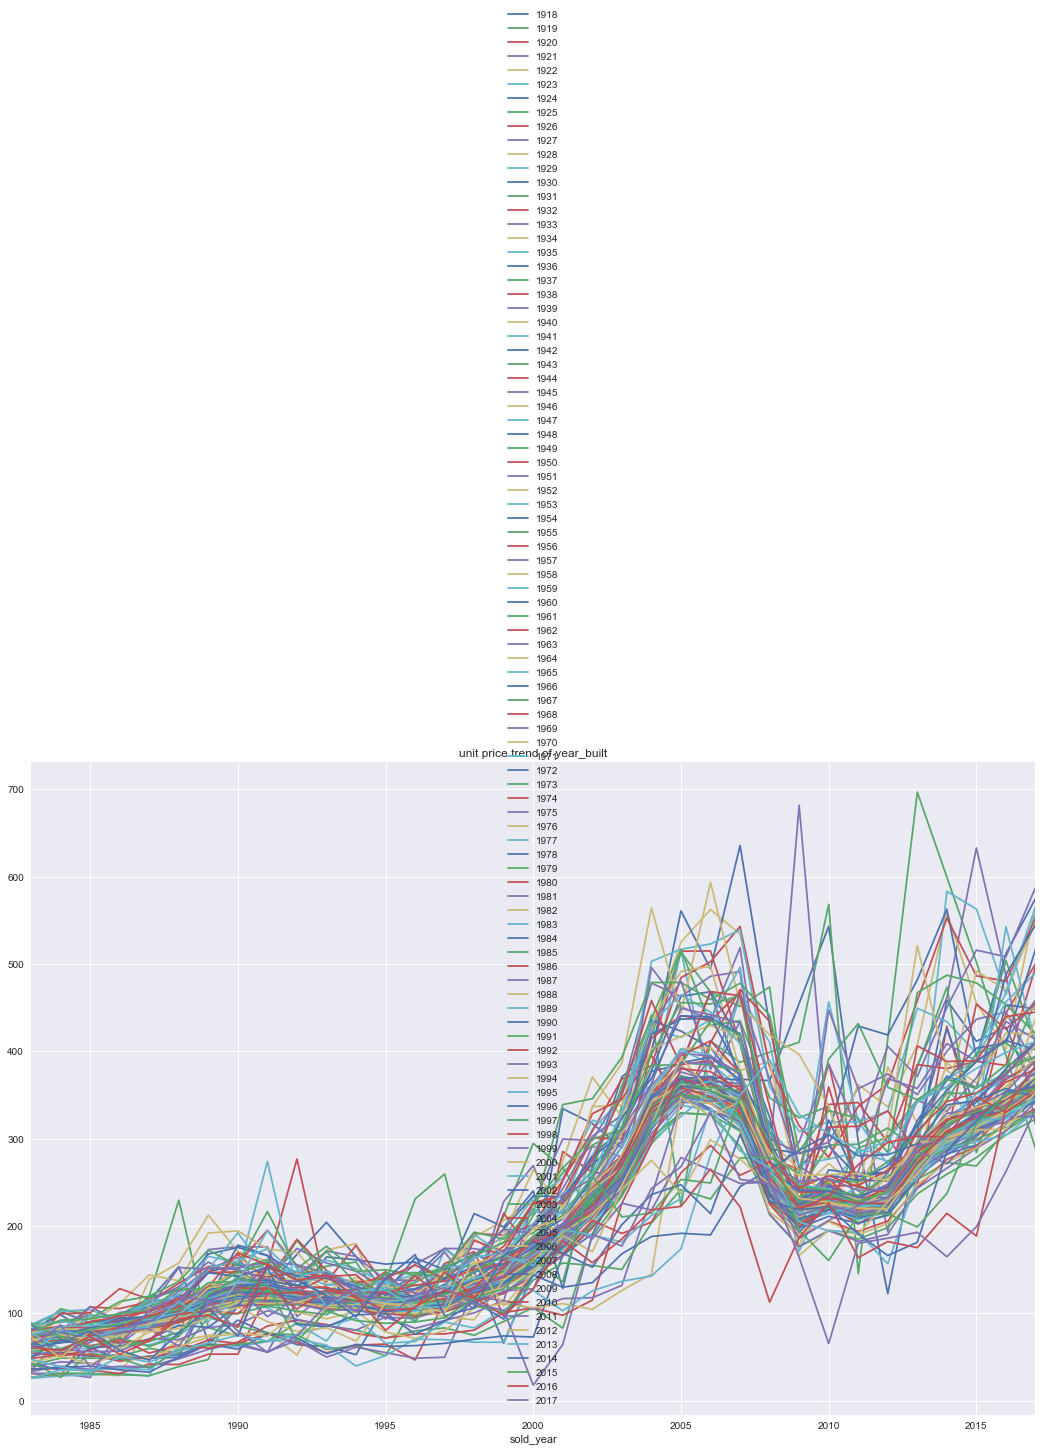

In [49]:
# segmented by year_built range
count = []
data = []
fig, ax = plt.subplots(figsize=(18,12))
for y in range(int(year_begin), int(year_end)+1):
    df_year_seg = df_all_valid[(df_all_valid['year_built']==y)]
    
    bracket = df_year_seg.groupby(by=['sold_year'])['unit_price']
    name = y
    #print(name, df_year_seg.shape[0])
    bracket_count = pd.Series(bracket.count(), name=name)
    count.append(bracket_count)
    df_year_seg = bracket.mean()
    data.append(pd.Series(df_year_seg, name=name))
    df_year_seg.plot(ax=ax, kind='line', label=name)
plt.legend(loc='best')
plt.title("unit price trend of year_built")
plt.show()

df_heat_year = pd.concat(count, axis=1, keys=[s.name for s in count])
df_trend_year = pd.concat(data, axis=1)

In [52]:
df_heat_year.min()

1918      1.0
1919      1.0
1920      3.0
1921      1.0
1922      2.0
1923      3.0
1924      2.0
1925      7.0
1926      6.0
1927      6.0
1928     12.0
1929     13.0
1930     18.0
1931      7.0
1932      1.0
1933      4.0
1934      2.0
1935     10.0
1936     10.0
1937     10.0
1938     15.0
1939     18.0
1940     33.0
1941     30.0
1942     45.0
1943     19.0
1944     15.0
1945     31.0
1946     32.0
1947     57.0
        ...  
1988    125.0
1989     98.0
1990    211.0
1991     85.0
1992     45.0
1993     29.0
1994     32.0
1995     56.0
1996     25.0
1997     16.0
1998     15.0
1999     20.0
2000     96.0
2001     15.0
2002     21.0
2003     19.0
2004     23.0
2005     51.0
2006     20.0
2007     18.0
2008     21.0
2009     19.0
2010     16.0
2011      8.0
2012      4.0
2013     10.0
2014      6.0
2015      9.0
2016      5.0
2017      2.0
Length: 100, dtype: float64

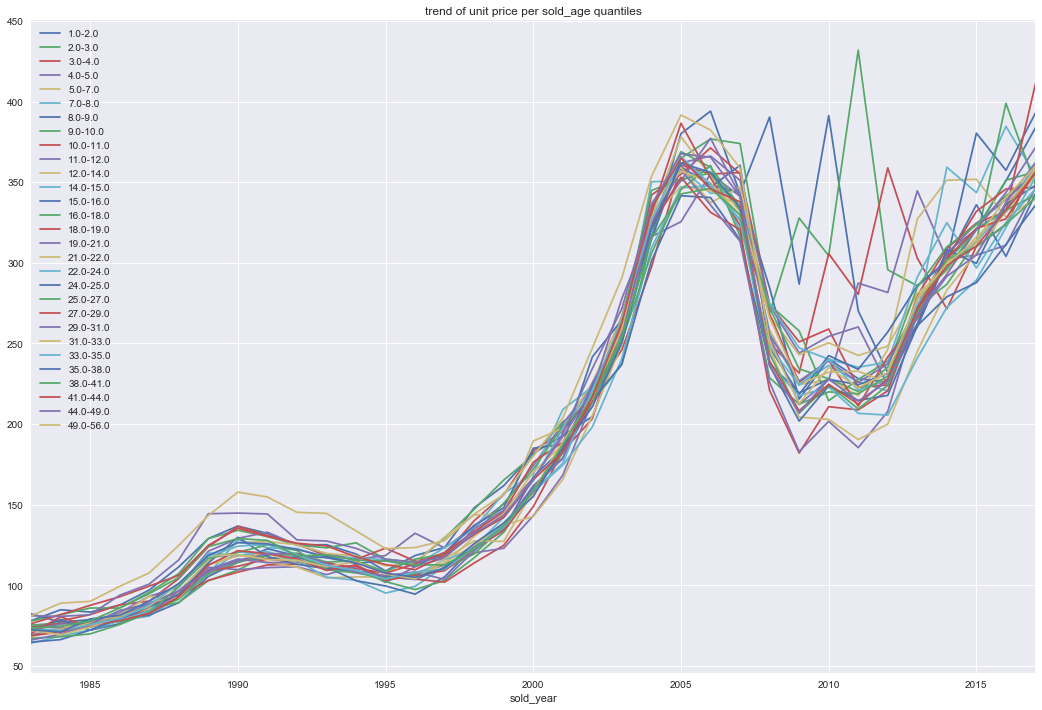

In [15]:
# segmented by year_built range
num_brackets = 30
year_segments = set([df_all_valid['sold_age'].quantile(i/num_brackets) for i in range(num_brackets)])
year_segments = sorted(list(year_segments))
count = []
data = []
fig, ax = plt.subplots(figsize=(18,12))
for i in range(len(year_segments)-1):
    year_b,year_e = year_segments[i], year_segments[i+1]
    df_year_seg = df_all_valid[(df_all_valid['sold_age']>=year_b) & (df_all_valid['sold_age']<year_e)]
    
    bracket = df_year_seg.groupby(by=['sold_year'])['unit_price']
    name = "{}-{}".format(year_b,year_e)
    #print(name, df_year_seg.shape[0])
    bracket_count = pd.Series(bracket.count(), name=name)
    count.append(bracket_count)
    df_year_seg = bracket.mean()
    data.append(pd.Series(df_year_seg, name=name))
    df_year_seg.plot(ax=ax, kind='line', label=name)
plt.legend(loc='best')
plt.title("trend of unit price per sold_age quantiles")
plt.show()

df_heat_year = pd.concat(count, axis=1, keys=[s.name for s in count])
df_trend = pd.concat(data, axis=1)

In [30]:
df_all_valid[(df_all_valid['sold_age']>=2)&(df_all_valid['sold_age']<3)
             &(df_all_valid['unit_price']>400)]

,pin,land_use_code,land_use_subcode,year_built,sqft,num_bed,num_bath,par_addition_area,num_units,par_current_land,...,unit_no,city,zip,code,sold_price,date,sold_age,unit_price,sold_year,sold_month
1936,3052811000,1,11,2015.0,2487,4.0,30.0,0,1,700000,...,None,SAN DIEGO,92130,,1120000,2017-09-08,2.0,450.341777,2017,9
2733,2230512300,1,11,2015.0,2228,4.0,30.0,0,1,565409,...,None,CARLSBAD,92009,,985000,2017-08-31,2.0,442.100539,2017,8
2932,4161821200,1,11,2015.0,3213,5.0,40.0,306,1,867000,...,None,SAN DIEGO,92109,,1940000,2017-08-30,2.0,603.797074,2017,8
3324,3052804100,1,11,2015.0,2077,4.0,30.0,0,1,466087,...,None,SAN DIEGO,92130,,938000,2017-08-25,2.0,451.612903,2017,8
3588,4535320500,1,11,2015.0,1448,2.0,20.0,0,1,309124,...,None,SAN DIEGO,92104,,635000,2017-08-23,2.0,438.535912,2017,8
4654,6786903502,1,17,2015.0,1628,3.0,25.0,0,1,302920,...,None,SAN DIEGO,92127,,658500,2017-08-14,2.0,404.484029,2017,8
6491,6774102809,1,17,2015.0,1630,2.0,25.0,0,1,403560,...,None,SAN DIEGO,92108,,759000,2017-07-28,2.0,465.644172,2017,7
6961,5313530434,1,17,2015.0,1800,2.0,35.0,0,1,800000,...,13,SAN DIEGO,92106,,1100000,2017-07-26,2.0,611.111111,2017,7
6965,5313530437,1,17,2015.0,2214,3.0,30.0,0,1,1000000,...,16,SAN DIEGO,92106,,1340000,2017-07-26,2.0,605.239386,2017,7
7241,6786911003,1,17,2015.0,1518,3.0,25.0,0,1,400000,...,None,SAN DIEGO,92127,,655000,2017-07-24,2.0,431.488801,2017,7
